## Target Obs Stratgey



> First, we need to import some packages in Julia

In [25]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI
using TimeSeries, Dates

  Activating project at `~/code/gitHub/CarbonI`


In [43]:
using XLSX, DataFrames, Dates, CairoMakie

# Read the Excel data
filename = "../../data/target_schedule_jun_updated_cap7days.xlsx"
sheetname = "target_schedule_jun_avail"
# The readtable function returns a tuple; we convert it to a DataFrame.
data = DataFrame(XLSX.readtable(filename, sheetname))
data_actual = DataFrame(XLSX.readtable(filename, "Prioritized_with_revisit"))

# Include our Colors:
include(joinpath("../../src/Plots", "CI_colorsNew.jl"))

In [44]:
# Convert the Overpass_Time column to DateTime objects.
# Adjust the date format string as needed to match your data.
data.Overpass_Time = DateTime.(data[!,"Start Time"]);
data_actual.Overpass_Time = DateTime.(data_actual[!,"Start Time"]);

In [45]:
data.Overpass_Time;
Day_Of_Year = dayofyear.(data.Overpass_Time);
Day_Of_Year_actual = dayofyear.(data_actual.Overpass_Time);

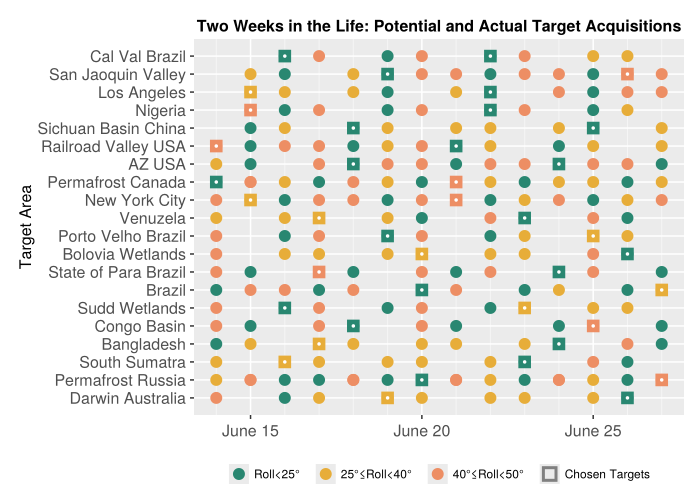

In [100]:

set_theme!(theme_ggplot2())
# Create a mapping for Target Area names to numeric indices for plotting.
targets = data[!,"Target Area Name"]
targets_actual = data_actual[!,"Target Area Name"]
rollAngles = convert.(Float64,data[!,"Roll Angle"])
rollAngles_actual = convert.(Float64,data_actual[!,"Roll Angle"])
areas = unique(targets)
areas_space = [replace(c, "_" => " ") for c in areas]
area_index = Dict(area => i for (i, area) in enumerate(areas))
data[!, :Area_Index] = [area_index[area] for area in targets]
data_actual[!, :Area_Index] = [area_index[area] for area in targets_actual]
#@show "b;a"
function get_color(roll)
    if roll < 25
        return CarbonI_colors[3]#:green
    elseif roll < 40
        return CarbonI_colors[1]#:orange
    else
        return CarbonI_colors[10]#:red
    end
end

colors_ = get_color.(rollAngles)
colors_actual = get_color.(rollAngles_actual)
#ta = TimeArray(data.Overpass_Time,  data.Area_Index)
#@show ta
#@show data.Overpass_Time
#@show data.Area_Index

# Create the scatter plot using CairoMakie
fig = Figure(resolution = (700, 500))
ax = Axis(fig[1, 1],
    #xlabel = "Day Of Year",
    ylabel = "Target Area",
    xticks = (15:5:25, ["June 15", "June 20", "June 25"]),
    yticks = (1:length(areas), areas_space),
    xminorgridvisible = true,xminorticks = IntervalsBetween(5),yminorgridvisible=false,
    title = "Two Weeks in the Life: Potential and Actual Target Acquisitions")

Offset = 165-14
# Create scatter plot: x-axis is Overpass_Time, y-axis is Area_Index, color coded by Roll_Angle.
ci = scatter!(ax, Day_Of_Year.-Offset, data.Area_Index,
    markersize = 17,
    color = colors_)

ci = scatter!(ax, Day_Of_Year_actual.-Offset, data_actual.Area_Index,
    markersize = 20,
    marker = :rect,
    color = colors_actual)       # Transparent fill
ci = scatter!(ax, Day_Of_Year_actual.-Offset, data_actual.Area_Index,
    markersize = 5,
    marker = :circle,
    color = :white) 
    #strokecolor = :gray,         # Black border
    #strokestyle = :dash,
    #strokewidth = 3)

    #colormap = :viridis)

dummy1 = scatter!(ax, [NaN], [NaN]; markersize = 17, color = CarbonI_colors[3], label = "Roll<25°")
dummy2 = scatter!(ax, [NaN], [NaN]; markersize = 17, color = CarbonI_colors[1], label = "25°≤Roll<40°")
dummy3 = scatter!(ax, [NaN], [NaN]; markersize = 17, color = CarbonI_colors[10], label = "40°≤Roll<50°")
dummy4 = scatter!(ax, [NaN], [NaN]; markersize = 20, marker = :rect, color = RGBA(0,0,0,0),
        strokecolor = :gray, strokewidth = 3, label = "Chosen Targets")
    
# Create and place the legend
#leg = Legend(fig, ax, nbanks = 1)
#fig[2, 1] = leg
# Create a horizontal legend using the dummy series
leg = Legend(fig, ax, orientation = :horizontal,labelsize=12)
# Place the legend in the second row spanning the full width
fig[2, 1] = leg

save("../../plots/final/TargetPotentialObs.pdf", fig)
fig

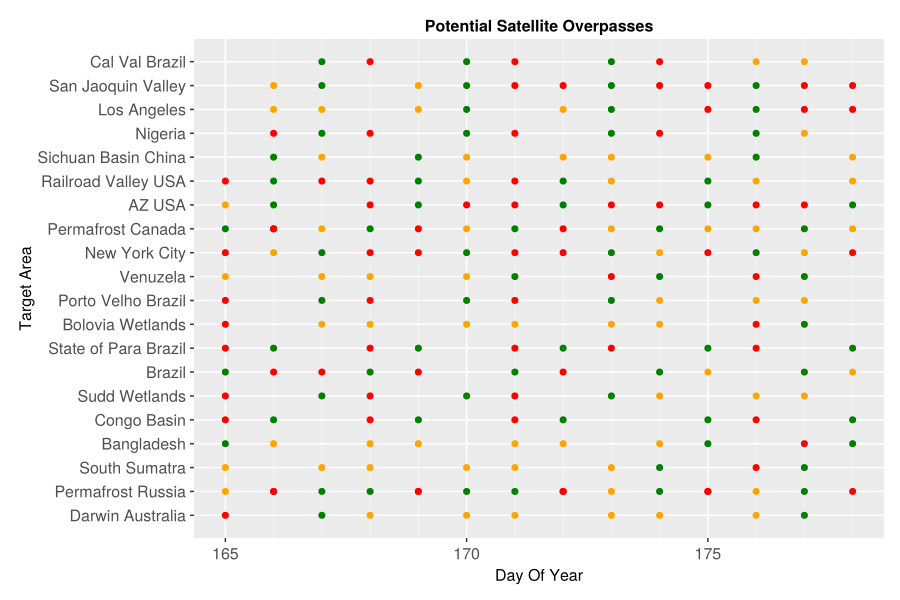

In [6]:
fig